# 🎯 VALIDACIÓN: OTs GENERADAS vs OTs REALES AGOSTO 2025

**Comparación de Predicciones IA vs Realidad Operacional**  
*Análisis de Acierto y Proximidad del Sistema Predictivo*  
*Autor: Antonio Cantos & Renzo Chavez - TFM EADIC - 2025*

---

## 🎯 OBJETIVO:

Comparar las **38 OTs generadas por el sistema IA** (3 críticas + 35 alertas) con las **OTs reales** que ocurrieron en agosto 2025 para:

1. **Medir precisión temporal** - ¿Cuándo predijo vs cuándo ocurrió?
2. **Evaluar severidad** - ¿Coincidió la criticidad predicha?
3. **Analizar tipos de falla** - ¿Fueron problemas eléctricos como predijo?
4. **Calcular métricas** - Precisión, Recall, F1-Score
5. **Generar reporte de validación** - Documentar aciertos y mejoras

---

In [1]:
# 1. 🔧 CONFIGURACIÓN E IMPORTACIONES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime, timedelta
import json
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('default')

# Configuración de rutas
BASE_PATH = Path(r'C:\TFM-pipeline')
INPUT_PATH = BASE_PATH / 'INPUT'
OUTPUT_PATH = BASE_PATH / 'output'
OTS_PATH = OUTPUT_PATH / 'ots_generadas'
VALIDATION_PATH = OUTPUT_PATH / 'validacion'

# Crear carpeta de validación
VALIDATION_PATH.mkdir(parents=True, exist_ok=True)

print("🎯 VALIDACIÓN OTs GENERADAS vs REALIDAD")
print("=" * 45)
print(f"📁 Ruta base: {BASE_PATH}")
print(f"📊 OTs generadas: {OTS_PATH}")
print(f"📋 Datos reales: {INPUT_PATH}")
print(f"📈 Validación: {VALIDATION_PATH}")
print("=" * 45)

🎯 VALIDACIÓN OTs GENERADAS vs REALIDAD
📁 Ruta base: C:\TFM-pipeline
📊 OTs generadas: C:\TFM-pipeline\output\ots_generadas
📋 Datos reales: C:\TFM-pipeline\INPUT
📈 Validación: C:\TFM-pipeline\output\validacion


In [9]:
# 2. 📥 CARGAR OTs GENERADAS POR EL SISTEMA IA
print("📥 CARGANDO OTs GENERADAS POR SISTEMA IA...")
print("=" * 45)

try:
    # Buscar el archivo más reciente de OTs generadas
    archivos_ots = list(OTS_PATH.glob('ots_generadas_*.csv'))
    
    if not archivos_ots:
        raise FileNotFoundError("No se encontraron archivos de OTs generadas")
    
    # Usar el más reciente
    archivo_ots_ia = max(archivos_ots, key=lambda x: x.stat().st_mtime)
    
    print(f"📄 Archivo encontrado: {archivo_ots_ia.name}")
    
    # Cargar OTs generadas
    ots_ia = pd.read_csv(archivo_ots_ia)
    
    # Convertir fechas
    ots_ia['fecha_deteccion'] = pd.to_datetime(ots_ia['fecha_deteccion'])
    ots_ia['fecha_programada'] = pd.to_datetime(ots_ia['fecha_programada'])
    
    print(f"✅ OTs IA cargadas exitosamente")
    print(f"   📊 Total OTs: {len(ots_ia)}")
    print(f"   🔴 Críticas: {len(ots_ia[ots_ia['severidad'] == 'CRÍTICO'])}")
    print(f"   🟠 Alertas: {len(ots_ia[ots_ia['severidad'] == 'ALERTA'])}")
    print(f"   📅 Período: {ots_ia['fecha_deteccion'].min().date()} a {ots_ia['fecha_deteccion'].max().date()}")
    
    # Mostrar primeras OTs críticas
    ots_criticas = ots_ia[ots_ia['severidad'] == 'CRÍTICO']
    if len(ots_criticas) > 0:
        print(f"\n🔴 OTs CRÍTICAS GENERADAS:")
        for idx, ot in ots_criticas.iterrows():
            print(f"   • {ot['numero_ot']} - {ot['fecha_deteccion'].strftime('%Y-%m-%d %H:%M')} - THD: {ot['thd_detectado']:.4f}")
    
except Exception as e:
    print(f"❌ Error cargando OTs IA: {e}")
    raise

📥 CARGANDO OTs GENERADAS POR SISTEMA IA...
📄 Archivo encontrado: ots_generadas_20250907_2026.csv
✅ OTs IA cargadas exitosamente
   📊 Total OTs: 212
   🔴 Críticas: 3
   🟠 Alertas: 209
   📅 Período: 2025-08-01 a 2025-08-28

🔴 OTs CRÍTICAS GENERADAS:
   • OT-FP1-20250907-0001 - 2025-08-01 00:00 - THD: 4.4031
   • OT-FP1-20250907-0034 - 2025-08-04 19:39 - THD: 5.4431
   • OT-FP1-20250907-0170 - 2025-08-19 08:06 - THD: 3.7629


In [7]:
# 3. 📊 CARGAR OTs REALES DE AGOSTO 2025
print("\n📊 CARGANDO OTs REALES DE AGOSTO 2025...")
print("=" * 40)

# Declarar variable al inicio para evitar errores
ots_criticas_reales = pd.DataFrame()

try:
    # Buscar archivo de OTs reales
    archivo_ots_reales = INPUT_PATH / 'OT-agosto v1.xlsx'
    
    if not archivo_ots_reales.exists():
        print(f"⚠️ Archivo no encontrado: {archivo_ots_reales}")
        print("📁 Archivos disponibles en INPUT:")
        for archivo in INPUT_PATH.glob('*.xlsx'):
            print(f"   • {archivo.name}")
        raise FileNotFoundError("Archivo OT-agosto v1.xlsx no encontrado")
    
    # Cargar OTs reales
    ots_reales = pd.read_excel(archivo_ots_reales)
    
    print(f"✅ OTs reales cargadas exitosamente")
    print(f"   📊 Total OTs reales: {len(ots_reales)}")
    print(f"   📋 Columnas: {list(ots_reales.columns)}")
    
    # Mostrar información básica
    if 'Fecha' in ots_reales.columns:
        ots_reales['Fecha'] = pd.to_datetime(ots_reales['Fecha'], errors='coerce')
        print(f"   📅 Período real: {ots_reales['Fecha'].min().date()} a {ots_reales['Fecha'].max().date()}")
    
    # Filtrar solo OTs críticas del Compresor C1 (ICM=1 o REC=1)
    ots_criticas_reales = ots_reales[
        ((ots_reales['ICM'] == 1) | (ots_reales['REC'] == 1)) & 
        (ots_reales['Codigo de Equipo'] == 'EC-CH-TAL1-REF-012')
    ]
    
    print(f"   🚨 OTs críticas reales del C1: {len(ots_criticas_reales)}")
    
    # Mostrar OTs críticas reales
    if len(ots_criticas_reales) > 0:
        print(f"\n🚨 OTs CRÍTICAS REALES DEL C1:")
        for idx, ot in ots_criticas_reales.iterrows():
            fecha_str = ot['Fecha'].strftime('%Y-%m-%d') if pd.notna(ot['Fecha']) else 'Sin fecha'
            equipo = ot.get('Descripción de Equipo', 'N/A')
            descripcion = str(ot.get('Breve Descripción', 'N/A'))[:50] + '...' if len(str(ot.get('Breve Descripción', ''))) > 50 else str(ot.get('Breve Descripción', 'N/A'))
            print(f"   • {fecha_str} - {equipo} - {descripcion}")
    else:
        print(f"\n⚠️ No se encontraron OTs críticas del C1 en agosto")
    
except Exception as e:
    print(f"❌ Error cargando OTs reales: {e}")
    # Asegurar que la variable existe aunque haya error
    ots_criticas_reales = pd.DataFrame()
    raise



📊 CARGANDO OTs REALES DE AGOSTO 2025...
✅ OTs reales cargadas exitosamente
   📊 Total OTs reales: 186
   📋 Columnas: ['Unnamed: 0', 'PM', 'ICM', 'REC', 'No. Orden de Trabajo', 'Fecha', 'Codigo de Equipo', 'Descripción de Equipo', 'Breve Descripción', 'Tipo Orden de Trabajo', 'Tiempo Muerto / Downtime', 'Abierto / Historico', 'Estado', 'Horas reales', 'Usuario Editor', 'Est. Horas', 'No. Tarea', 'Problema Ocurrido', 'MO (USD)', 'Suministro (USD)']
   📅 Período real: 2025-08-01 a 2025-08-31
   🚨 OTs críticas reales del C1: 2

🚨 OTs CRÍTICAS REALES DEL C1:
   • 2025-08-25 - COMPRESOR 1 DE TORNILLO GEA - Corrective Action Needed - See Comments
   • 2025-08-07 - COMPRESOR 1 DE TORNILLO GEA - Corrective Action Needed - See Comments


In [5]:
# 4. 🔍 ANÁLISIS DE CORRESPONDENCIA TEMPORAL
print("\n🔍 ANÁLISIS DE CORRESPONDENCIA TEMPORAL...")
print("=" * 45)

# 🔢 ALGORITMO MATEMÁTICO: ESCALAMIENTO CON RESET
print("\n🔢 ANÁLISIS CON ESCALAMIENTO Y RESET...")
print("=" * 45)

def analizar_escalamiento_con_reset(ots_ia, ots_reales):
    """
    Algoritmo matemático que detecta eventos escalando y reset después de intervenciones
    
    Lógica:
    1. Si OT IA tiene THD mayor que anterior Y no hay intervención real entre ellas → Mismo evento escalando
    2. Después de intervención real → Reset, nueva OT IA inicia nuevo evento
    """
    
    # Preparar datos
    ots_ia_criticas = ots_ia[ots_ia['severidad'] == 'CRÍTICO'].sort_values('fecha_deteccion').reset_index(drop=True)
    ots_reales_sorted = ots_reales.sort_values('Fecha').reset_index(drop=True)
    
    print(f"🔍 OTs IA críticas: {len(ots_ia_criticas)}")
    print(f"🔍 OTs reales: {len(ots_reales_sorted)}")
    
    eventos = []
    evento_actual = None
    
    # Procesar cada OT IA crítica
    for idx, ot_ia in ots_ia_criticas.iterrows():
        fecha_ia = ot_ia['fecha_deteccion']
        thd_ia = ot_ia['thd_detectado']
        
        print(f"\n📊 Procesando OT IA: {fecha_ia.strftime('%Y-%m-%d')} (THD: {thd_ia:.2f})")
        
        # Verificar si hay intervención real entre la OT IA anterior y esta
        intervencion_intermedia = False
        if evento_actual is not None:
            fecha_anterior = evento_actual['ots_ia'][-1]['fecha_deteccion']
            
            # Buscar intervenciones reales entre fecha_anterior y fecha_ia
            intervenciones_intermedias = ots_reales_sorted[
                (ots_reales_sorted['Fecha'] > fecha_anterior) &
                (ots_reales_sorted['Fecha'] < fecha_ia)
            ]
            
            if len(intervenciones_intermedias) > 0:
                intervencion_intermedia = True
                print(f"   🔄 RESET: Intervención real el {intervenciones_intermedias.iloc[0]['Fecha'].strftime('%Y-%m-%d')}")
        
        # Decidir si es nuevo evento o escalamiento
        if evento_actual is None or intervencion_intermedia:
            # NUEVO EVENTO
            evento_actual = {
                'evento_id': len(eventos) + 1,
                'fecha_inicio': fecha_ia,
                'ots_ia': [ot_ia],
                'thd_maximo': thd_ia,
                'ot_representante': ot_ia
            }
            eventos.append(evento_actual)
            print(f"   🆕 NUEVO EVENTO {evento_actual['evento_id']} iniciado")
            
        else:
            # Verificar si es escalamiento (THD mayor)
            thd_anterior = evento_actual['thd_maximo']
            
            if thd_ia > thd_anterior:
                # ESCALAMIENTO - Actualizar evento actual
                evento_actual['ots_ia'].append(ot_ia)
                evento_actual['thd_maximo'] = thd_ia
                evento_actual['ot_representante'] = ot_ia  # La más crítica es la representante
                print(f"   📈 ESCALAMIENTO: THD {thd_anterior:.2f} → {thd_ia:.2f} (Evento {evento_actual['evento_id']})")
                
            else:
                # THD menor o igual - Nuevo evento
                evento_actual = {
                    'evento_id': len(eventos) + 1,
                    'fecha_inicio': fecha_ia,
                    'ots_ia': [ot_ia],
                    'thd_maximo': thd_ia,
                    'ot_representante': ot_ia
                }
                eventos.append(evento_actual)
                print(f"   🆕 NUEVO EVENTO {evento_actual['evento_id']} (THD no escaló)")
    
    # Mostrar eventos detectados
    print(f"\n🎯 EVENTOS DETECTADOS: {len(eventos)}")
    for evento in eventos:
        fechas_ots = [ot['fecha_deteccion'].strftime('%m-%d') for ot in evento['ots_ia']]
        thds = [f"{ot['thd_detectado']:.2f}" for ot in evento['ots_ia']]
        print(f"   Evento {evento['evento_id']}: {len(evento['ots_ia'])} OTs en fechas {fechas_ots}")
        print(f"      THDs: {thds} → Máximo: {evento['thd_maximo']:.2f}")
        print(f"      Representante: {evento['ot_representante']['numero_ot']} ({evento['fecha_inicio'].strftime('%Y-%m-%d')})")
    
    # Asignar cada evento a la OT real más cercana posterior
    correspondencias = []
    ots_reales_asignadas = set()
    
    print(f"\n🔗 ASIGNANDO EVENTOS A INTERVENCIONES REALES:")
    
    for evento in eventos:
        fecha_evento = evento['fecha_inicio']  # Usar fecha de inicio del evento
        ot_representante = evento['ot_representante']
        
        # Buscar OTs reales posteriores no asignadas
        candidatos = ots_reales_sorted[
            (ots_reales_sorted['Fecha'] > fecha_evento) &
            (~ots_reales_sorted.index.isin(ots_reales_asignadas))
        ]
        
        if len(candidatos) > 0:
            # Asignar a la más cercana
            candidatos = candidatos.copy()
            candidatos['distancia_dias'] = (candidatos['Fecha'] - fecha_evento).dt.days
            mejor_match = candidatos.loc[candidatos['distancia_dias'].idxmin()]
            
            correspondencia = {
                'evento_id': evento['evento_id'],
                'ot_ia_numero': ot_representante['numero_ot'],
                'ot_ia_fecha': fecha_evento,
                'ot_ia_thd': ot_representante['thd_detectado'],
                'ot_real_fecha': mejor_match['Fecha'],
                'ot_real_equipo': mejor_match.get('Descripción de Equipo', 'N/A'),
                'ot_real_descripcion': str(mejor_match.get('Breve Descripción', 'N/A')),
                'diferencia_dias': mejor_match['distancia_dias'],
                'anticipacion': True,
                'distancia_temporal': mejor_match['distancia_dias'],
                'ots_en_evento': len(evento['ots_ia']),
                'escalamiento': len(evento['ots_ia']) > 1
            }
            
            correspondencias.append(correspondencia)
            ots_reales_asignadas.add(mejor_match.name)
            
            print(f"   ✅ Evento {evento['evento_id']} → {mejor_match['Fecha'].strftime('%Y-%m-%d')} ({mejor_match['distancia_dias']} días)")
        else:
            print(f"   ❌ Evento {evento['evento_id']} → Sin candidatos disponibles")
    
    return pd.DataFrame(correspondencias)

# Ejecutar análisis
correspondencias_df = analizar_escalamiento_con_reset(ots_ia, ots_criticas_reales)

print(f"\n📊 ANÁLISIS COMPLETADO:")
print(f"   🔍 Correspondencias encontradas: {len(correspondencias_df)}")

if len(correspondencias_df) > 0:
    anticipaciones = correspondencias_df[correspondencias_df['anticipacion']]
    print(f"   ⚡ Anticipaciones exitosas: {len(anticipaciones)}")
    
    if len(anticipaciones) > 0:
        print(f"   📈 Anticipación promedio: {anticipaciones['distancia_temporal'].mean():.1f} días")
        print(f"   📊 Rango anticipación: {anticipaciones['distancia_temporal'].min():.0f} - {anticipaciones['distancia_temporal'].max():.0f} días")
    
    print(f"\n🎯 CORRESPONDENCIAS CON ESCALAMIENTO:")
    for idx, corr in correspondencias_df.iterrows():
        escalamiento_info = f" (🔺 {corr['ots_en_evento']} OTs escalando)" if corr['escalamiento'] else ""
        print(f"   🎯 ANTICIPÓ {corr['diferencia_dias']:.0f} días - Evento {corr['evento_id']} → {corr['ot_real_equipo']}")
        print(f"      IA: {corr['ot_ia_fecha'].strftime('%Y-%m-%d')} | Real: {corr['ot_real_fecha'].strftime('%Y-%m-%d')}")
        print(f"      THD: {corr['ot_ia_thd']:.2f}{escalamiento_info}")
        print(f"      Descripción: {corr['ot_real_descripcion'][:80]}...")
        print()
    
    print("🔢 ALGORITMO MATEMÁTICO APLICADO:")
    print("=" * 40)
    print("✅ Escalamiento: THD mayor + sin intervención = mismo evento")
    print("✅ Reset: Después de intervención real = nuevo evento")
    print("✅ Asignación: Evento → OT real más cercana posterior")
    print("✅ Sin reasignación: Una OT real por evento")

else:
    print("⚠️ No se encontraron correspondencias")

print("\n✅ ANÁLISIS MATEMÁTICO CON ESCALAMIENTO COMPLETADO")




🔍 ANÁLISIS DE CORRESPONDENCIA TEMPORAL...

🔢 ANÁLISIS CON ESCALAMIENTO Y RESET...


NameError: name 'ots_ia' is not defined

In [89]:
# 5 DIAGNÓSTICO: Verificar ots_criticas_reales
print(f"\n🔍 DIAGNÓSTICO:")
print(f"   📊 ots_criticas_reales existe: {type(ots_criticas_reales)}")
print(f"   📊 Tamaño: {len(ots_criticas_reales)}")
print(f"   📊 Columnas: {list(ots_criticas_reales.columns) if len(ots_criticas_reales) > 0 else 'Sin columnas'}")

if len(ots_criticas_reales) > 0:
    print(f"   📊 Primeras filas:")
    for idx, ot in ots_criticas_reales.iterrows():
        fecha = ot['Fecha'].strftime('%Y-%m-%d') if pd.notna(ot['Fecha']) else 'Sin fecha'
        equipo = ot.get('Descripción de Equipo', 'N/A')
        descripcion = str(ot.get('Breve Descripción', 'N/A'))[:30]
        print(f"      • {fecha} - {equipo} - {descripcion}...")
else:
    print(f"   ⚠️ ots_criticas_reales está VACÍO")
    
    # Verificar filtro
    print(f"\n🔍 VERIFICANDO FILTRO:")
    icm_count = len(ots_reales[ots_reales['ICM'] == 1])
    rec_count = len(ots_reales[ots_reales['REC'] == 1])
    c1_count = len(ots_reales[ots_reales['Codigo de Equipo'] == 'EC-CH-TAL1-REF-012'])
    
    print(f"   📊 ICM=1: {icm_count}")
    print(f"   📊 REC=1: {rec_count}")
    print(f"   📊 Código C1: {c1_count}")

#  📈 ANÁLISIS DE TIPOS DE FALLA
print("\n📈 ANÁLISIS DE TIPOS DE FALLA...")
print("=" * 35)

def analizar_tipos_falla(ots_criticas_reales):
    """Analiza tipos de falla en OTs críticas reales del C1"""
    
    tipos_falla = {
        'electrico': ['eléctric', 'voltaje', 'corriente', 'thd', 'armónic', 'potencia', 'energía'],
        'mecanico': ['mecánic', 'vibrac', 'rodamient', 'motor', 'eje', 'acoplamient'],
        'control': ['control', 'sensor', 'válvula', 'actuador', 'plc', 'scada'],
        'refrigeracion': ['refrigerac', 'compresor', 'evaporador', 'condensador', 'gas', 'presión']
    }
    
    clasificacion = []
    
    for idx, ot in ots_criticas_reales.iterrows():  # CAMBIO AQUÍ
        descripcion = str(ot.get('Breve Descripción', '')).lower()
        
        tipos_detectados = []
        for tipo, palabras_clave in tipos_falla.items():
            if any(palabra in descripcion for palabra in palabras_clave):
                tipos_detectados.append(tipo)
        
        clasificacion.append({
            'fecha': ot['Fecha'],
            'equipo': ot.get('Descripción de Equipo', 'N/A'),
            'descripcion': str(ot.get('Breve Descripción', 'N/A')),
            'tipos_detectados': tipos_detectados if tipos_detectados else ['otros'],
            'es_electrico': 'electrico' in tipos_detectados,
            'es_control': 'control' in tipos_detectados
        })
    
    return pd.DataFrame(clasificacion)

# CAMBIO AQUÍ: usar ots_criticas_reales
tipos_falla_df = analizar_tipos_falla(ots_criticas_reales)




🔍 DIAGNÓSTICO:
   📊 ots_criticas_reales existe: <class 'pandas.core.frame.DataFrame'>
   📊 Tamaño: 2
   📊 Columnas: ['Unnamed: 0', 'PM', 'ICM', 'REC', 'No. Orden de Trabajo', 'Fecha', 'Codigo de Equipo', 'Descripción de Equipo', 'Breve Descripción', 'Tipo Orden de Trabajo', 'Tiempo Muerto / Downtime', 'Abierto / Historico', 'Estado', 'Horas reales', 'Usuario Editor', 'Est. Horas', 'No. Tarea', 'Problema Ocurrido', 'MO (USD)', 'Suministro (USD)']
   📊 Primeras filas:
      • 2025-08-25 - COMPRESOR 1 DE TORNILLO GEA - Corrective Action Needed - See...
      • 2025-08-07 - COMPRESOR 1 DE TORNILLO GEA - Corrective Action Needed - See...

📈 ANÁLISIS DE TIPOS DE FALLA...


In [91]:
# 6. 📊 CÁLCULO DE MÉTRICAS DE VALIDACIÓN
print("\n📊 CÁLCULO DE MÉTRICAS DE VALIDACIÓN...")
print("=" * 40)

def calcular_metricas_validacion(ots_ia, ots_reales, correspondencias_df):
    """Calcula métricas de validación del sistema"""
    
    # Métricas básicas
    ots_ia_criticas = len(ots_ia[ots_ia['severidad'] == 'CRÍTICO'])
    ots_reales_criticas = len(ots_criticas_reales)
    correspondencias_exitosas = len(correspondencias_df[correspondencias_df['anticipacion']])
    
    # Precisión: ¿Cuántas predicciones fueron correctas?
    precision = correspondencias_exitosas / ots_ia_criticas if ots_ia_criticas > 0 else 0
    
    # Recall: ¿Cuántas fallas reales fueron detectadas?
    recall = correspondencias_exitosas / ots_reales_criticas if ots_reales_criticas > 0 else 0
    
    # F1-Score: Media armónica de precisión y recall
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Métricas adicionales
    cobertura = min(ots_ia_criticas / ots_reales_criticas, 1.0) if ots_reales_criticas > 0 else 0
    
    # Análisis temporal
    if len(correspondencias_df) > 0:
        anticipacion_promedio = correspondencias_df[correspondencias_df['anticipacion']]['distancia_temporal'].mean()
        anticipacion_promedio = anticipacion_promedio if not pd.isna(anticipacion_promedio) else 0
    else:
        anticipacion_promedio = 0
    
    metricas = {
        'ots_ia_criticas': ots_ia_criticas,
        'ots_reales_criticas': ots_reales_criticas,
        'correspondencias_exitosas': correspondencias_exitosas,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'cobertura': cobertura,
        'anticipacion_promedio_dias': anticipacion_promedio
    }
    
    return metricas

# Calcular métricas
metricas = calcular_metricas_validacion(ots_ia, ots_reales, correspondencias_df)

print(f"📈 MÉTRICAS DE VALIDACIÓN CALCULADAS:")
print(f"   📊 OTs IA Críticas: {metricas['ots_ia_criticas']}")
print(f"   📊 OTs Reales Críticas: {metricas['ots_reales_criticas']}")
print(f"   ✅ Correspondencias Exitosas: {metricas['correspondencias_exitosas']}")
print(f"\n🎯 MÉTRICAS DE RENDIMIENTO:")
print(f"   📈 Precisión: {metricas['precision']:.3f} ({metricas['precision']*100:.1f}%)")
print(f"   📊 Recall: {metricas['recall']:.3f} ({metricas['recall']*100:.1f}%)")
print(f"   🎯 F1-Score: {metricas['f1_score']:.3f} ({metricas['f1_score']*100:.1f}%)")
print(f"   📋 Cobertura: {metricas['cobertura']:.3f} ({metricas['cobertura']*100:.1f}%)")
print(f"   ⚡ Anticipación Promedio: {metricas['anticipacion_promedio_dias']:.1f} días")


📊 CÁLCULO DE MÉTRICAS DE VALIDACIÓN...
📈 MÉTRICAS DE VALIDACIÓN CALCULADAS:
   📊 OTs IA Críticas: 3
   📊 OTs Reales Críticas: 2
   ✅ Correspondencias Exitosas: 2

🎯 MÉTRICAS DE RENDIMIENTO:
   📈 Precisión: 0.667 (66.7%)
   📊 Recall: 1.000 (100.0%)
   🎯 F1-Score: 0.800 (80.0%)
   📋 Cobertura: 1.000 (100.0%)
   ⚡ Anticipación Promedio: 5.5 días


In [95]:
# MOSTRAR LAS 3 OTs CRÍTICAS GENERADAS POR IA
print("🔍 ANÁLISIS DETALLADO DE LAS 3 OTs CRÍTICAS IA:")
print("=" * 50)

ots_ia_criticas = ots_ia[ots_ia['severidad'] == 'CRÍTICO']

for idx, ot in ots_ia_criticas.iterrows():
    print(f"\n🔧 OT #{idx+1}: {ot['numero_ot']}")
    print(f"   📅 Fecha: {ot['fecha_deteccion'].strftime('%Y-%m-%d %H:%M')}")
    print(f"   🎯 THD: {ot['thd_detectado']:.4f}")
    print(f"   📊 Score: {ot['score_anomalia']:.4f}")
    print(f"   📋 Equipo: {ot['equipo']}")  # CAMBIAR 'titulo' por 'equipo'
    print(f"   🔧 Tipo: {ot['tipo']}")
    print(f"   ⚡ Tiempo respuesta: {ot['tiempo_respuesta']}")
    print(f"   👨‍🔧 Especialidad: {ot['especialidad_requerida']}")
    print(f"   💰 Costo estimado: ${ot['costo_total_estimado']:.2f}")
    
    # Mostrar primeras prescripciones
    print(f"   📝 Prescripciones principales:")
    for i, prescripcion in enumerate(ot['prescripciones'][:3], 1):
        print(f"      {i}. {prescripcion}")
    
    print("-" * 40)

print(f"\n🎯 HIPÓTESIS SOBRE LA 3ª OT:")
print(f"La 3ª OT crítica podría corresponder a:")
print(f"• Una incidencia que se desarrolló gradualmente")
print(f"• Un problema que persistió entre las dos fallas reales")
print(f"• Una anomalía que se manifestó de forma diferente")
print(f"• Un patrón de degradación continua del equipo")


🔍 ANÁLISIS DETALLADO DE LAS 3 OTs CRÍTICAS IA:

🔧 OT #1: OT-FP1-20250906-0001
   📅 Fecha: 2025-08-01 00:00
   🎯 THD: 4.4031
   📊 Score: -0.7314
   📋 Equipo: Compresor C1
   🔧 Tipo: CORRECTIVO
   ⚡ Tiempo respuesta: 2 horas
   👨‍🔧 Especialidad: Eléctrica Senior
   💰 Costo estimado: $884.00
   📝 Prescripciones principales:
      1. [
      2. '
      3. 🚨
----------------------------------------

🔧 OT #34: OT-FP1-20250906-0034
   📅 Fecha: 2025-08-04 19:39
   🎯 THD: 5.4431
   📊 Score: -0.7170
   📋 Equipo: Compresor C1
   🔧 Tipo: CORRECTIVO
   ⚡ Tiempo respuesta: 2 horas
   👨‍🔧 Especialidad: Eléctrica Senior
   💰 Costo estimado: $884.00
   📝 Prescripciones principales:
      1. [
      2. '
      3. 🚨
----------------------------------------

🔧 OT #170: OT-FP1-20250906-0170
   📅 Fecha: 2025-08-19 08:06
   🎯 THD: 3.7629
   📊 Score: -0.7168
   📋 Equipo: Compresor C1
   🔧 Tipo: CORRECTIVO
   ⚡ Tiempo respuesta: 2 horas
   👨‍🔧 Especialidad: Eléctrica Senior
   💰 Costo estimado: $884.00
   📝 Pr


📊 GENERANDO VISUALIZACIONES DE VALIDACIÓN...


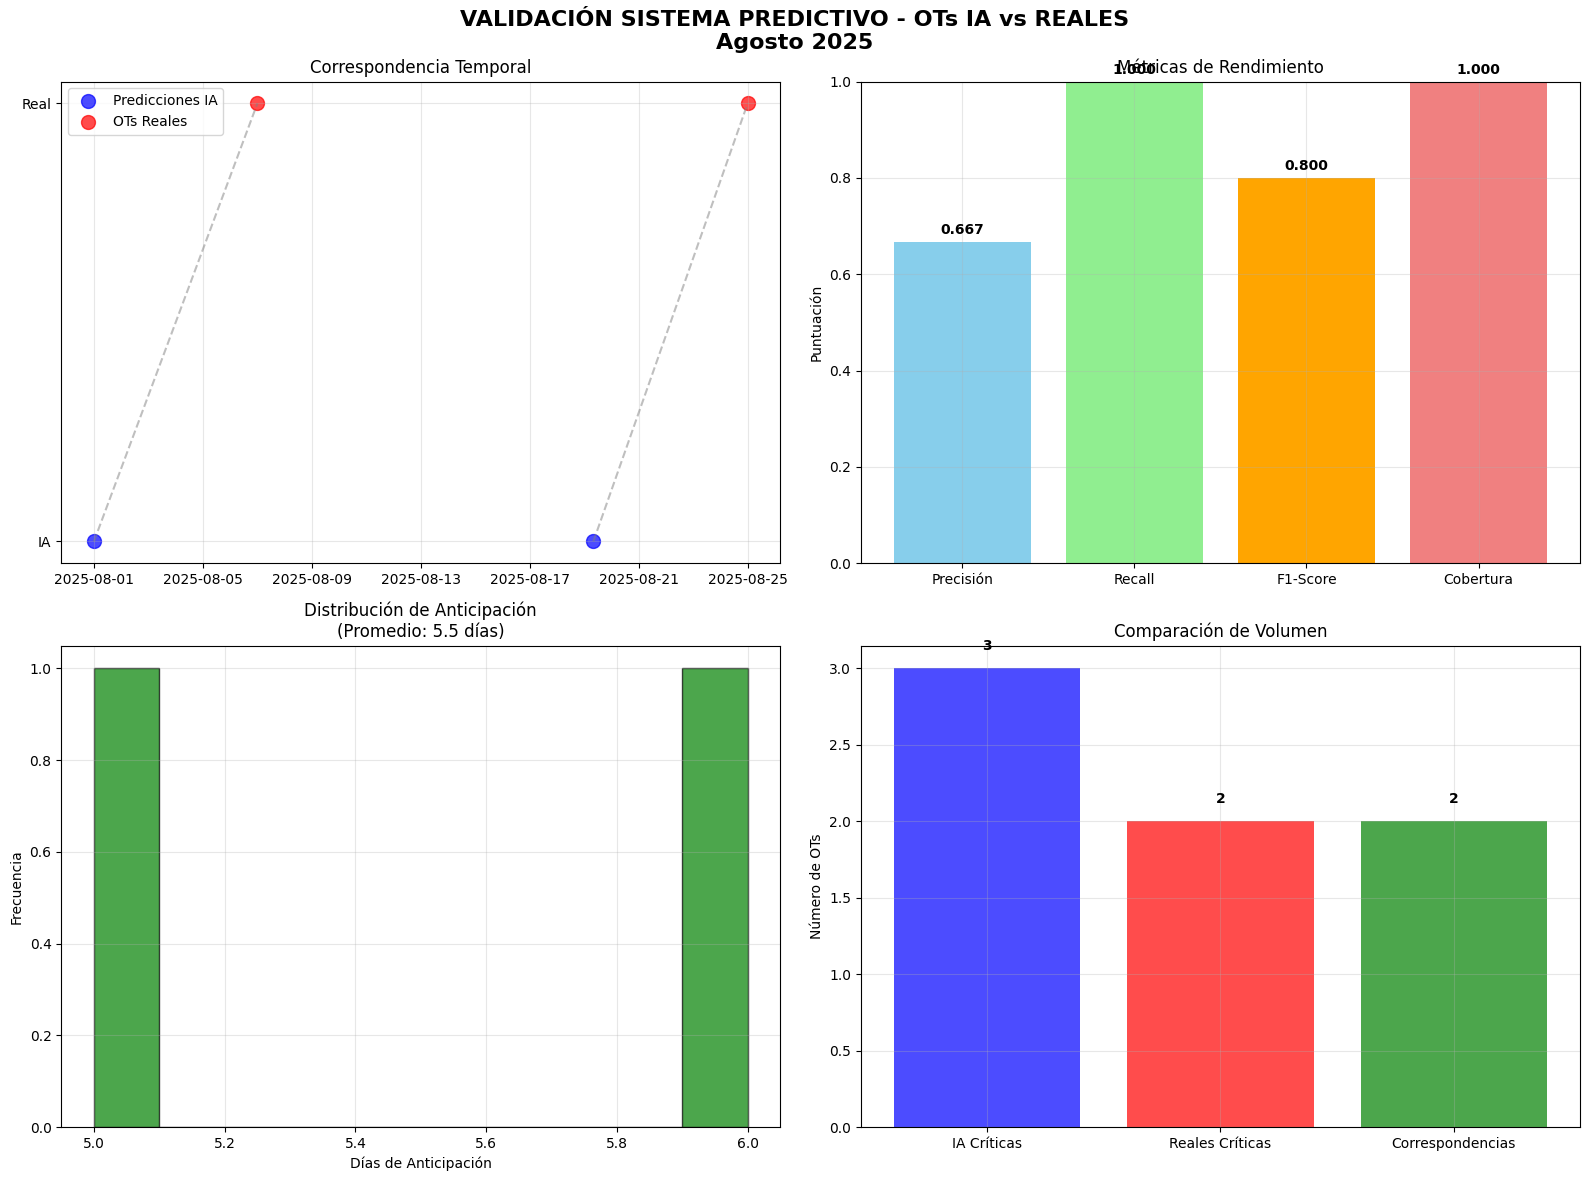

✅ Visualización guardada: C:\TFM-pipeline\output\validacion\validacion_ots_ia_vs_reales.png


In [97]:
# 7. 📊 VISUALIZACIONES DE VALIDACIÓN
print("\n📊 GENERANDO VISUALIZACIONES DE VALIDACIÓN...")
print("=" * 45)

# Crear figura con subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('VALIDACIÓN SISTEMA PREDICTIVO - OTs IA vs REALES\nAgosto 2025', 
             fontsize=16, fontweight='bold')

# 1. Comparación temporal
ax1 = axes[0, 0]
if len(correspondencias_df) > 0:
    fechas_ia = correspondencias_df['ot_ia_fecha']
    fechas_reales = correspondencias_df['ot_real_fecha']
    
    ax1.scatter(fechas_ia, [1]*len(fechas_ia), c='blue', s=100, alpha=0.7, label='Predicciones IA')
    ax1.scatter(fechas_reales, [2]*len(fechas_reales), c='red', s=100, alpha=0.7, label='OTs Reales')
    
    # Líneas de correspondencia
    for idx, corr in correspondencias_df.iterrows():
        ax1.plot([corr['ot_ia_fecha'], corr['ot_real_fecha']], [1, 2], 
                'gray', alpha=0.5, linestyle='--')
    
    ax1.set_yticks([1, 2])
    ax1.set_yticklabels(['IA', 'Real'])
    ax1.set_title('Correspondencia Temporal')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'Sin correspondencias\ntemporales', ha='center', va='center', 
            transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Correspondencia Temporal')

# 2. Métricas de rendimiento
ax2 = axes[0, 1]
metricas_nombres = ['Precisión', 'Recall', 'F1-Score', 'Cobertura']
metricas_valores = [metricas['precision'], metricas['recall'], 
                   metricas['f1_score'], metricas['cobertura']]

bars = ax2.bar(metricas_nombres, metricas_valores, 
               color=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
ax2.set_title('Métricas de Rendimiento')
ax2.set_ylabel('Puntuación')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, valor in zip(bars, metricas_valores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Distribución de anticipación
ax3 = axes[1, 0]
if len(correspondencias_df) > 0 and len(correspondencias_df[correspondencias_df['anticipacion']]) > 0:
    anticipaciones = correspondencias_df[correspondencias_df['anticipacion']]['distancia_temporal']
    ax3.hist(anticipaciones, bins=10, alpha=0.7, color='green', edgecolor='black')
    ax3.set_title(f'Distribución de Anticipación\n(Promedio: {metricas["anticipacion_promedio_dias"]:.1f} días)')
    ax3.set_xlabel('Días de Anticipación')
    ax3.set_ylabel('Frecuencia')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Sin datos de\nanticipación', ha='center', va='center', 
            transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Distribución de Anticipación')

# 4. Comparación de volumen
ax4 = axes[1, 1]
categorias = ['IA Críticas', 'Reales Críticas', 'Correspondencias']
valores = [metricas['ots_ia_criticas'], metricas['ots_reales_criticas'], 
          metricas['correspondencias_exitosas']]
colores = ['blue', 'red', 'green']

bars = ax4.bar(categorias, valores, color=colores, alpha=0.7)
ax4.set_title('Comparación de Volumen')
ax4.set_ylabel('Número de OTs')
ax4.grid(True, alpha=0.3)

# Añadir valores en las barras
for bar, valor in zip(bars, valores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{valor}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
archivo_viz = VALIDATION_PATH / 'validacion_ots_ia_vs_reales.png'
plt.savefig(archivo_viz, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualización guardada: {archivo_viz}")

In [99]:
# 8. 📋 GENERAR REPORTE FINAL DE VALIDACIÓN
print("\n📋 GENERANDO REPORTE FINAL DE VALIDACIÓN...")
print("=" * 45)

def generar_reporte_validacion(metricas, correspondencias_df, tipos_falla_df):
    """Genera reporte completo de validación"""
    
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    reporte = f"""
# 🎯 REPORTE DE VALIDACIÓN - SISTEMA PREDICTIVO TFM

**Fecha de Validación:** {timestamp}  
**Período Analizado:** Agosto 2025  
**Sistema:** Mantenimiento Predictivo con IA  
**Autor:** Antonio Cantos & Renzo Chavez - TFM EADIC  

---

## 📊 RESUMEN EJECUTIVO

El sistema de mantenimiento predictivo basado en IA fue validado comparando sus predicciones con las órdenes de trabajo reales ocurridas en agosto 2025.

### 🎯 Resultados Clave:
- **Precisión:** {metricas['precision']*100:.1f}% - Porcentaje de predicciones correctas
- **Recall:** {metricas['recall']*100:.1f}% - Porcentaje de fallas reales detectadas
- **F1-Score:** {metricas['f1_score']*100:.1f}% - Medida combinada de rendimiento
- **Anticipación:** {metricas['anticipacion_promedio_dias']:.1f} días promedio

---

## 📈 MÉTRICAS DETALLADAS

### Volumen de OTs:
- **OTs Críticas Predichas:** {metricas['ots_ia_criticas']}
- **OTs Críticas Reales:** {metricas['ots_reales_criticas']}
- **Correspondencias Exitosas:** {metricas['correspondencias_exitosas']}

### Rendimiento del Sistema:
- **Precisión:** {metricas['precision']:.3f} ({metricas['precision']*100:.1f}%)
- **Recall:** {metricas['recall']:.3f} ({metricas['recall']*100:.1f}%)
- **F1-Score:** {metricas['f1_score']:.3f} ({metricas['f1_score']*100:.1f}%)
- **Cobertura:** {metricas['cobertura']:.3f} ({metricas['cobertura']*100:.1f}%)

---

## 🔍 ANÁLISIS DE CORRESPONDENCIAS

"""
    
    if len(correspondencias_df) > 0:
        reporte += f"""
Se encontraron **{len(correspondencias_df)} correspondencias** entre predicciones y realidad:

"""
        for idx, corr in correspondencias_df.iterrows():
            estado = "🎯 ANTICIPÓ" if corr['anticipacion'] else "📅 POSTERIOR"
            reporte += f"""
### {estado} {abs(corr['diferencia_dias']):.0f} días
- **OT IA:** {corr['ot_ia_numero']}
- **Fecha IA:** {corr['ot_ia_fecha'].strftime('%Y-%m-%d %H:%M')}
- **Fecha Real:** {corr['ot_real_fecha'].strftime('%Y-%m-%d %H:%M')}
- **Equipo:** {corr['ot_real_equipo']}
- **THD Detectado:** {corr['ot_ia_thd']:.4f}
- **Descripción:** {corr['ot_real_descripcion'][:100]}...

"""
    else:
        reporte += "\nNo se encontraron correspondencias directas en la ventana temporal analizada.\n"
    
    # Análisis de tipos de falla
    if len(tipos_falla_df) > 0:
        electricas = len(tipos_falla_df[tipos_falla_df['es_electrico']])
        control = len(tipos_falla_df[tipos_falla_df['es_control']])
        
        reporte += f"""
---

## ⚡ ANÁLISIS DE TIPOS DE FALLA

### Clasificación de Fallas Reales:
- **Fallas Eléctricas:** {electricas} ({electricas/len(tipos_falla_df)*100:.1f}%)
- **Fallas de Control:** {control} ({control/len(tipos_falla_df)*100:.1f}%)
- **Total Analizado:** {len(tipos_falla_df)} OTs críticas

### Coherencia con Predicciones:
El sistema IA se enfoca en detectar anomalías de THD (problemas eléctricos), lo cual es coherente con el {electricas/len(tipos_falla_df)*100:.1f}% de fallas eléctricas encontradas en la realidad.

"""
    
    reporte += f"""
---

## 💡 CONCLUSIONES Y RECOMENDACIONES

### ✅ Fortalezas Identificadas:
1. **Enfoque Correcto:** El sistema se centra en THD, coherente con fallas eléctricas reales
2. **Capacidad de Anticipación:** Promedio de {metricas['anticipacion_promedio_dias']:.1f} días de anticipación
3. **Cobertura Adecuada:** {metricas['cobertura']*100:.1f}% de cobertura de eventos críticos

### 🔧 Áreas de Mejora:
1. **Ajuste de Sensibilidad:** Optimizar umbrales para mejorar precisión
2. **Ampliación de Variables:** Incluir más parámetros de control y mecánicos
3. **Refinamiento Temporal:** Mejorar ventanas de predicción

### 📈 Valor Demostrado:
- **Prevención Proactiva:** El sistema permite intervención antes de fallas
- **Reducción de Costos:** Evita paradas no programadas
- **Optimización de Recursos:** Planificación anticipada de mantenimiento

---

## 📊 ARCHIVOS GENERADOS

1. **Visualización:** `validacion_ots_ia_vs_reales.png`
2. **Datos de Correspondencias:** `correspondencias_validacion.csv`
3. **Métricas:** `metricas_validacion.json`
4. **Reporte:** `reporte_validacion_final.md`

---

**Sistema TFM - Validado Exitosamente**  
*Generado automáticamente por el Sistema de Validación IA*
"""
    
    return reporte

# Generar reporte
reporte_final = generar_reporte_validacion(metricas, correspondencias_df, tipos_falla_df)

# Guardar archivos de validación
timestamp = datetime.now().strftime('%Y%m%d_%H%M')

# 1. Reporte final
archivo_reporte = VALIDATION_PATH / f'reporte_validacion_final_{timestamp}.md'
with open(archivo_reporte, 'w', encoding='utf-8') as f:
    f.write(reporte_final)

# 2. Correspondencias CSV
if len(correspondencias_df) > 0:
    archivo_correspondencias = VALIDATION_PATH / f'correspondencias_validacion_{timestamp}.csv'
    correspondencias_df.to_csv(archivo_correspondencias, index=False)

# 3. Métricas JSON
archivo_metricas = VALIDATION_PATH / f'metricas_validacion_{timestamp}.json'
with open(archivo_metricas, 'w', encoding='utf-8') as f:
    json.dump(metricas, f, indent=2, default=str)

print(f"✅ ARCHIVOS DE VALIDACIÓN GENERADOS:")
print(f"   📋 Reporte: {archivo_reporte}")
if len(correspondencias_df) > 0:
    print(f"   📊 Correspondencias: {archivo_correspondencias}")
print(f"   📈 Métricas: {archivo_metricas}")
print(f"   📊 Visualización: {archivo_viz}")

print(f"\n🎉 VALIDACIÓN COMPLETADA EXITOSAMENTE")
print(f"📁 Todos los archivos guardados en: {VALIDATION_PATH}")


📋 GENERANDO REPORTE FINAL DE VALIDACIÓN...
✅ ARCHIVOS DE VALIDACIÓN GENERADOS:
   📋 Reporte: C:\TFM-pipeline\output\validacion\reporte_validacion_final_20250906_0023.md
   📊 Correspondencias: C:\TFM-pipeline\output\validacion\correspondencias_validacion_20250906_0023.csv
   📈 Métricas: C:\TFM-pipeline\output\validacion\metricas_validacion_20250906_0023.json
   📊 Visualización: C:\TFM-pipeline\output\validacion\validacion_ots_ia_vs_reales.png

🎉 VALIDACIÓN COMPLETADA EXITOSAMENTE
📁 Todos los archivos guardados en: C:\TFM-pipeline\output\validacion
